In [1]:
# ranking functions
# loader from standard data

In [2]:
import networkx as nx
import numpy as np
from itertools import chain,combinations
import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [4]:
def find_max_weight_edge(sim_graph):
    # Search for
    max_weight = -1
    tu = 0
    tv = 0
    vertex_count = sim_graph.number_of_nodes()
    for u in range(0,vertex_count):
        linked_nodes = sim_graph.adj[u]
        for v in list(linked_nodes):
            w = sim_graph.edges[u,v]["weight"]
            print("u="+str(u) + "," + str(v) + ",weight=" + str(w))
            if (w > max_weight):
                tu = u
                tv = v
                max_weight = w
    return tu,tv, max_weight

In [5]:
def delete_edges_from(graph, vertex):
    e = graph.adj[vertex]
    for linked in list(e):
        graph.remove_edge(vertex,linked)

In [6]:
def sort_by_metric_func(graph):
    return list(graph.nodes())

In [7]:
def get_metric_ranking(rankings, num):
    return rankings.index(num)

In [8]:
# Eqn 2 in diversification paper
def calc_compdist_from(graph, i, j, lam):
    dimension_dist = 0
    i_props = graph.nodes[i]
    j_props = graph.nodes[j]
    
    rankings = sort_by_metric_func(graph)
    ranking_i = get_metric_ranking(rankings, i)
    ranking_j = get_metric_ranking(rankings, j)
    print("ranking_i" + str(ranking_i))
    print("ranking_j" + str(ranking_j))
    
    # Get the properties
    for k,v in i_props.items():
        # Dimension values only
        if "d" in k:
            dist = (v - j_props[k])
            dimension_dist += (dist ** 2.0)
            
    comp_value = ranking_i + ranking_j + 2 * lam * np.sqrt(dimension_dist)
    print("dimension_dist = " + str(dimension_dist))
    print("comp_value = " + str(comp_value))
    return comp_value
    

In [9]:
# Need to add arbitrary vertex
def max_sum_divergence_approx(sim_graph, phy_count):
    Phy = nx.Graph() 
    lim = int(np.floor(phy_count/2))
    for i in range(0,lim):
        mu, mv, weight = find_max_weight_edge(sim_graph)
        if (mu != mv):
            print("Max weight: " + str(mu) + "->" + str(mv) + ",weight=" + str(weight))
            Phy.add_node(mu)
            Phy.add_node(mv)
            Phy.add_edge(mu,mv)
            Phy.edges[mu,mv]["weight"] = sim_graph.edges[mu,mv]["weight"]
            print("Number of edges in Phy=" + str(Phy.number_of_edges()))
            # remove other connected edges from mu and mv in the s\im_graph
            delete_edges_from(sim_graph, mu)
            delete_edges_from(sim_graph, mv)
            # check further
        
    # If phy_count is odd, add a random vertex
    # for now, only use an even phy_count
    return Phy

In [10]:
def gen_node_props(metrics_count, dim_count, metric_max, dim_max):
    nodeprops = {}
    metrics = []
    
    for di in range(0, dim_count):
        rand_dim = np.random.uniform(low=0, high=dim_max)
        nodeprops["d" + str(di)] = rand_dim
        
    # Generate the metrics
    for mi in range(0,metrics_count):
        rand_metric = np.random.uniform(low=0, high=metric_max)
        metrics.append(rand_metric)
        nodeprops["m" + str(mi)] = rand_metric
    return nodeprops

In [11]:
def create_random_sim_graph(node_count, metric_count, metric_max, dim_count, dim_max):
    sim = nx.Graph();
    for i in range(0,node_count):
        sim.add_nodes_from([(i, gen_node_props(metric_count, dim_count, metric_max, dim_max))])
        # weights are now calculated for the algorithm
        #sim.nodes[i]["ranking"] = ranking_func(sim, node_id)
        
    # add connections from all nodes, depending on their distance 
    for i in range(0, node_count):
        for j in range(0, node_count):
            if (i != j):
                sim.add_edge(i,j)
                # weights are now calculated for the algorithm
                
                #weight = calc_compdist_from(Sim, i, j, lam)
                #Sim.edges[i,j]["weight"] = weight
                #print("Adding edge from " + str(i) + "->" + str(j) + ", weight = " + str(Sim.edges[i,j]["weight"]))
                #print(Sim.edges[i, j])
    print("Edges: = " + str(sim.number_of_edges()))
    return sim

In [12]:
# TODO: simple ranking function is the sum of the metrics
# TODO: metrics would need to be scaled somehow
def ranking_func(graph,node_id):
    props = graph.nodes[node_id]
    total = 0
    for k,v in props.items():
        if "m" in k:
            total += v
    return total

In [ ]:
# dist_sum theoretical max = k * (k-1) * sqrt(param_space_num_dimesions)
# assuming all dimensions are properly normalised from zero to one!

# weight_sum theortical max = k * max_rank

In [14]:
def calc_subset_value_function(graph, subset_inds, lam):
    k = len(subset_inds)
    weight_sum = 0
    for ni in subset_inds:
    # ranking_func is w in the equation
        weight_sum += ranking_func(graph, ni)
    
    # Are we double counting the distance here?
    # dist_sum has to be normalised over the number of dimensions?
    # the 2 is to compensate for counting them only once?
    # not needed here?
    dist_sum = 0
    for ni in subset_inds:
        for nj in subset_inds:
            dist_sum += dist_func(graph, ni,nj)
            
    total = (k-1)*weight_sum + 2*lam*dist_sum
    return total

In [13]:
def dist_func(graph, ni, nj):
    i_props = graph.nodes[ni]
    j_props = graph.nodes[nj]
    dimension_dist = 0.0
    for k,v in i_props.items():
    # Dimension values only
        if "d" in k:
            dist = (v - j_props[k])
            dimension_dist += (dist ** 2.0)
    return np.sqrt(dimension_dist)

In [15]:
def subset_value(graph, subset, lam):
    value = calc_subset_value_function(graph, subset, lam)
    return (subset, value)

In [16]:
def subset_cost(subset):
    return len(subset)

In [25]:
def meets_cost_constraint(subset):
    return (subset_cost(subset) <= FIXED_COST_BUDGET)

In [18]:
def subsets_viable_sorted_by_cost(simgraph, lam):
    all_subsets = list(powerset(simgraph.nodes()))
    viable_subsets = filter(meets_cost_constraint, all_subsets)
    subset_info = map(lambda subset: subset_value(simgraph, subset, lam), viable_subsets)
    return sorted(subset_info, key=lambda info: info[1], reverse=True)

In [19]:
#%matplotlib widget

In [20]:
# Plot the surface and the graph between them
def plot_graph_with_edges_from_subset(g, edge_set):
    MAX_MARKER_SIZE = 10
    
    x = np.array(list(map(lambda n: g.nodes[n]['d0'], g)))
    y = np.array(list(map(lambda n: g.nodes[n]['d1'], g)))
    z = np.array(list(map(lambda n: g.nodes[n]['d2'], g)))
    # 3d spring layout
    pos = np.vstack((x, y, z)).T
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(g)])
    
    node_ranks = np.array(list(map(lambda n: (MAX_MARKER_SIZE * ranking_func(g, n))**2.0, g)))
    
    edge_id_set = itertools.combinations(edge_selection, r=2)
    edge_xyz = np.array([(pos[t[0]], pos[t[1]]) for t in edge_id_set])

    # Create the 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=node_ranks, ec="w")

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color="tab:gray")
    
    #_format_axes(ax)
    fig.tight_layout()
    plt.show()


In [21]:
FIXED_COST_BUDGET = 5

max_dimension = 1 / np.sqrt(3)
sim = create_random_sim_graph(20, 2, 1.0, 3, max_dimension)
phy = subsets_viable_sorted_by_cost(sim, 1.0)
sim

Edges: = 190


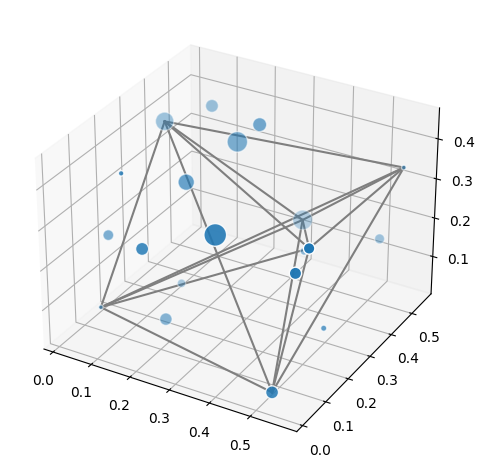

In [28]:
use_approx_algorithm = False

plt.close()

# TODO: how to normalise for correct lambda
lam = 10.0
FIXED_COST_BUDGET = 6

if use_approx_algorithm:
    phy_best = max_sum_divergence_approx(sim, lam)    
else:
    phy = subsets_viable_sorted_by_cost(sim, lam)
    phy_best = phy[0]
    
selection_to_plot = phy_best
edge_selection = selection_to_plot[0]
plot_graph_with_edges_from_subset(sim, edge_selection)